# Using metrics in Eager mode
----

Hello everyone! In this tutorial, we are going to learn how to use various metrics in order to assess the performance of our neural networks when using the Eager mode in TensorFlow. 

I've played quite a bit with TensorFlow in Eager mode and I love it. The API seems very intuitive to me and everything seems so much easier to build now, compared to when I was using the declarative mode. The main inconvenient that I've found for now (I am using version 1.7) is that _tf.metrics_ is not yet compatible when using the eager mode. Nevertheless, I have constructed several functions that can help you assess the performance of your network whilst still enjoying the awesomeness of building your networks on the fly. 

### Tutorial steps:
----
![img](tutorials_graphics/02_flowchart.png)

I have chosen to work on three cases:
* **Multi-Classification** 
>For this task, we are going to use the __*accuracy*__, __*confusion matrix*__ and __*average precision*__ and __*recall*__ in order to evaluate the performance of the our model.
* **Imbalanced Binary Classification**
>When we are dealing with an imbalanced dataset, the accuracy of a model is not a reliable metric. Thus, we will use the __*ROC-AUC*__ score, which seems to be a more appropriate metric for imbalanced problems.
* **Regression**
> To assess the performance of our regression model, we will be using the $\boldsymbol{R^2}$ score (coefficient of determination).

I believe these cases are diverse enough to help you in any machine learning project you will encounter further. 
If you would like me to add any extra metrics that are not encountered below, please let me know and I will do my best to add them later on. So, let's get started :)!

** TensorFlow version used - 1.7 **


## Import useful libraries and enable eager mode
----

In [2]:
# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import functions to generate toy classication problems
from sklearn.datasets import load_wine
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression

# Import numpy for data preprocessing
import numpy as np

# Import library for plots
import matplotlib.pyplot as plt
%matplotlib inline

# Import PCA for dimensionality reduction
from sklearn.decomposition import PCA

In [3]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution()

## Part I: Dataset for multi-classification
----

In [4]:
wine_data = load_wine()

In [5]:
print('Type of data in the wine_data dictionary: ', list(wine_data.keys()))

Type of data in the wine_data dictionary:  ['data', 'target', 'target_names', 'DESCR', 'feature_names']


In [6]:
print('Number of classes: ', len(np.unique(wine_data.target)))

Number of classes:  3


In [7]:
print('Distribution of our targets: ', np.unique(wine_data.target, return_counts=True)[1])

Distribution of our targets:  [59 71 48]


In [8]:
print('Number of features in the dataset: ', wine_data.data.shape[1])

Number of features in the dataset:  13


### Standardize features
----
The scale of each feature varies a lot as you can see in the cell below. In order to speed up the training, we will normalize each feature to have zero mean and unit standard deviation. This process is called standardization and it is very helpful in the convergence of the neural network. 

In [9]:
# Standardize dataset
wine_data.data = (wine_data.data - np.mean(wine_data.data, axis=0))/np.std(wine_data.data, axis=0)

In [10]:
print('Standard deviation of each feature after standardization: ', np.std(wine_data.data, axis=0))

Standard deviation of each feature after standardization:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


###  Data visualization. Use PCA to reduce the dimensionality to 2D.
----
We will use PCA, only for visualization purposes. We will be training our neural network using all 13 features. 

Let's have a look at how these 3 classes are represented in the 2D space.

In [11]:
X_pca = PCA(n_components=2, random_state=2018).fit_transform(wine_data.data)

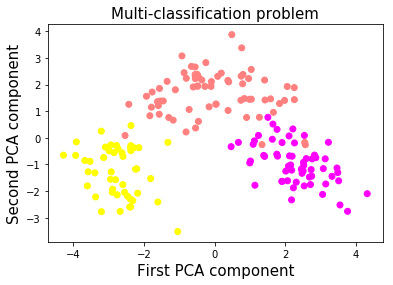

In [12]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=wine_data.target, cmap=plt.cm.spring)
plt.xlabel('First PCA component', fontsize=15)
plt.ylabel('Second PCA component', fontsize=15)
plt.title('Multi-classification problem', fontsize=15)
plt.show()

Okay, so it appears that the classes are easily separable. By the way, I actually tried using PCA before standardizing the features and the pink and yellow classes were overlapping. By standardizing the features before reducing the dimensionality we managed to obtain a much clear boundary between them. 

### Let's build a two-layers neural network using the TensorFlow Eager API
----

As you might have noticed, the most convenient way to build models using TensorFlow Eager is with classes. I think that using classes for your models makes it much easier to organize and adding new components to it. You simply define the layers that you're going to use during initialization and use them later on at the predict stage. It makes it easier to read the architecture of the model during the predict stage.

In [13]:
class two_layer_nn(tf.keras.Model):
    def __init__(self, output_size=2, loss_type='cross-entropy'):
        super(two_layer_nn, self).__init__()
        """ Define here the layers used during the forward-pass 
            of the neural network.     
            Args:
                output_size: int (default=2). 
                loss_type: string, 'cross-entropy' or 'regression' (default='cross-entropy')
        """   
        # First hidden layer
        self.dense_1 = tf.layers.Dense(20, activation=tf.nn.relu)
        # Second hidden layer
        self.dense_2 = tf.layers.Dense(10, activation=tf.nn.relu)
        # Output layer. Unscaled log probabilities
        self.dense_out = tf.layers.Dense(output_size, activation=None)     
        # Initialize loss type
        self.loss_type = loss_type
    
    def predict(self, input_data):
        """ Runs a forward-pass through the network.     
            Args:
                input_data: 2D tensor of shape (n_samples, n_features).   
            Returns:
                logits: unnormalized predictions.
        """
        layer_1 = self.dense_1(input_data)
        layer_2 = self.dense_2(layer_1)
        logits = self.dense_out(layer_2)
        return logits
    
    def loss_fn(self, input_data, target):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(input_data)
        if self.loss_type=='cross-entropy':
            loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=preds)
        else:
            loss = tf.losses.mean_squared_error(target, preds)
        return loss
    
    def grads_fn(self, input_data, target):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(input_data, target)
        return tape.gradient(loss, self.variables)
    
    def fit(self, input_data, target, optimizer, num_epochs=500, 
            verbose=50, track_accuracy=True):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. It also stores the accuracy
            of the model after each epoch.
        """   
        
        if track_accuracy:
            # Initialize list to store the accuracy of the model
            self.hist_accuracy = []     
            # Initialize class to compute the accuracy metric
            accuracy = tfe.metrics.Accuracy()

        for i in range(num_epochs):
            # Take a step of gradient descent
            grads = self.grads_fn(input_data, target)
            optimizer.apply_gradients(zip(grads, self.variables))
            if track_accuracy:
                # Predict targets after taking a step of gradient descent
                logits = self.predict(X)
                preds = tf.argmax(logits, axis=1)
                # Compute the accuracy
                accuracy(preds, target)
                # Get the actual result and add it to our list
                self.hist_accuracy.append(accuracy.result())
                # Reset accuracy value (we don't want to track the running mean accuracy)
                accuracy.init_variables()


### Accuracy metric
----
To assess the performance of our model using the accuracy metric, we will be using the 'tfe.metrics.Accuracy' class. This metric is really useful when training a model in batches, as it computes the mean accuracy across batches each time it is called. As we train our model with the entire dataset at each step, we will be resetting this metric, as we do not want it to track the running mean.

In [14]:
# Create input features and targets dataset. Transfer data from numpy to tensors.
X = tf.constant(wine_data.data)
y = tf.constant(wine_data.target)

In [15]:
# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(5e-1)

# Initialize model 
model = two_layer_nn(output_size=3)

# Select here the number of epochs
num_epochs=5

# Train the model with gradient descent
model.fit(X, y, optimizer, num_epochs=num_epochs)

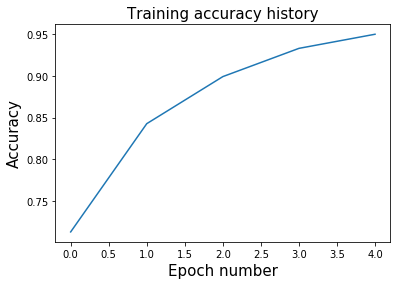

In [16]:
plt.plot(range(num_epochs), model.hist_accuracy);
plt.xlabel('Epoch number', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.title('Training accuracy history', fontsize=15);

### Confusion matrix
----
Visualizing the confusion matrix after you finished training the algorithm is a great way to give you global overview on the performance of your network. TensorFlow has a built-in function to compute the confusion matrix and fortunately it is compatible with eager mode. So let's visualize the confusion matrix of this dataset.

In [17]:
# Get the predictions on the entire dataset
logits = model.predict(X)
preds = tf.argmax(logits, axis=1)

In [18]:
# Print confusion matrix
conf_matrix = tf.confusion_matrix(y, preds, num_classes=3)
print('Confusion matrix: \n', conf_matrix.numpy())

Confusion matrix: 
 [[56  3  0]
 [ 2 66  3]
 [ 0  1 47]]


The diagonal matrix shows the true positives whilst the lower and upper bound of the matrix shows the false positives.

### Precision score
----
The confusion matrix computed above makes it extremely easy to compute the mean average precision. I will implement a function below, which computes it automatically for you. You can also specify the weights of each class. For example, maybe the precision for class 2 is more important for you for some reason.

In [19]:
def precision(labels, predictions, weights=None):
    conf_matrix = tf.confusion_matrix(labels, predictions, num_classes=3)
    tp_and_fp = tf.reduce_sum(conf_matrix, axis=0)
    tp = tf.diag_part(conf_matrix)
    precision_scores = tp/(tp_and_fp)
    if weights:
        precision_score = tf.multiply(precision_scores, weights)/tf.reduce_sum(weights)
    else:
        precision_score = tf.reduce_mean(precision_scores)        
    return precision_score

In [20]:
precision_score = precision(y, preds, weights=None)
print('Average precision: ', precision_score.numpy())

Average precision:  0.9494581280788177


### Recall score
----
The average recall can be computed very similarly with the precision. Instead of summing the columns, we are going to sum the rows in order to get the total number of true positives and false negatives.

In [21]:
def recall(labels, predictions, weights=None):
    conf_matrix = tf.confusion_matrix(labels, predictions, num_classes=3)
    tp_and_fn = tf.reduce_sum(conf_matrix, axis=1)
    tp = tf.diag_part(conf_matrix)
    recall_scores = tp/(tp_and_fn)
    if weights:
        recall_score = tf.multiply(recall_scores, weights)/tf.reduce_sum(weights)
    else:
        recall_score = tf.reduce_mean(recall_scores)        
    return recall_score

In [22]:
recall_score = recall(y, preds, weights=None)
print('Average precision: ', recall_score.numpy())

Average precision:  0.9526322246094269


## Part II: Imbalanced binary classification
----
When you'll start working with real datasets, you will quickly come to notice that most of the problems are kinda imbalanced. For example, anomaly detection problems are severely imbalanced given the proportion of anomalous samples in comparison with the normal ones. In these cases, a more suitable metric to assess the performance of your network is the ROC-AUC score. So, let's build our imbalanced dataset and start working on it :)!

In [23]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                           n_redundant=0, n_classes=2, n_clusters_per_class=1,
                           flip_y=0.1, class_sep=4, hypercube=False, 
                           shift=0.0, scale=1.0, random_state=2018)

# Reduce the number of samples with target 1
X = np.vstack([X[y==0], X[y==1][:50]])
y = np.hstack([y[y==0], y[y==1][:50]])

### Visualizing the dataset
----

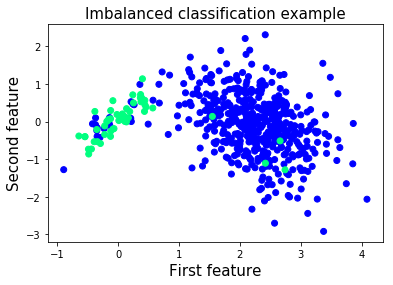

In [24]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.winter)
plt.xlabel('First feature', fontsize=15)
plt.ylabel('Second feature', fontsize=15)
plt.title('Imbalanced classification example', fontsize=15)
plt.show()

We will be using the same neural network architecture. We just have to initialize the model with num_classes=2, as we're working with a binary classification problem.

In [25]:
# Numpy arrays to tensors
X = tf.constant(X)
y = tf.constant(y)

Let's train the model just for a few epochs, in order to avoid overfitting.

In [26]:
# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(5e-1)

# Initialize model 
model = two_layer_nn(output_size=2)

# Select here the number of epochs
num_epochs = 5

# Train the model with gradient descent
model.fit(X, y, optimizer, num_epochs=num_epochs)

### How to compute the ROC-AUC score
----
To compute the ROC-AUC score, we will use the same methodology as in *tf.metric.auc*. For each probability threshold, we will be computing the number of *true positives*, *true negatives*, *false positives* and *false negatives*. After computing these statistics, we can compute the true positive rate and false positive rate for each probability threshold. 

To approximate the area under the ROC curve, we will be using *Riemann sums* and the *trapezoidal rule*. If you would like to find more info on this you can have look [here](https://www.khanacademy.org/math/ap-calculus-ab/ab-accumulation-riemann-sums/ab-midpoint-trapezoid/a/understanding-the-trapezoid-rule).

### ROC-AUC Function
----

In [27]:
def roc_auc(labels, predictions, thresholds, get_fpr_tpr=True):
    tpr = []
    fpr = []
    for th in thresholds:    
        # Compute number of true positives
        tp_cases = tf.where((tf.greater_equal(predictions, th)) & 
                            (tf.equal(labels, 1)))
        tp = tf.size(tp_cases)
        
        # Compute number of true negatives
        tn_cases = tf.where((tf.less(predictions, th)) & 
                            (tf.equal(labels, 0)))
        tn = tf.size(tn_cases)
        
        # Compute number of false positives
        fp_cases = tf.where((tf.greater_equal(predictions, th)) & 
                            (tf.equal(labels,0)))
        fp = tf.size(fp_cases)
        
        # Compute number of false negatives
        fn_cases = tf.where((tf.less(predictions, th)) & 
                            (tf.equal(labels,1)))
        fn = tf.size(fn_cases)
        
        # Compute True Positive Rate for this threshold
        tpr_th = tp/(tp + fn)
        
        # Compute the False Positive Rate for this threshold
        fpr_th = fp/(fp + tn)
        
        # Append to the entire True Positive Rate list
        tpr.append(tpr_th)
        
        # Append to the entire False Positive Rate list
        fpr.append(fpr_th)
        
    # Approximate area under the curve using Riemann sums and the trapezoidal rule
    auc_score = 0
    for i in range(0, len(thresholds)-1):
        height_step = tf.abs(fpr[i+1]-fpr[i])
        b1 = tpr[i]
        b2 = tpr[i+1]
        step_area = height_step*(b1+b2)/2
        auc_score += step_area
    return auc_score, fpr, tpr

### Compute the ROC-AUC score of our trained model and plot the ROC curve
----

In [28]:
# More thresholds means higher granularity for the area under the curve approximation
# Feel free to experiment with the number of thresholds
num_thresholds = 1000 
thresholds = tf.lin_space(0.0, 1.0, num_thresholds).numpy()

In [29]:
# Apply Softmax on our predictions as the output of the model is unnormalized
# Select the predictions of our positive class (the class with less samples)
preds = tf.nn.softmax(model.predict(X))[:,1] 

# Compute the ROC-AUC score and get the TPR and FPR of each threshold
auc_score, fpr_list, tpr_list = roc_auc(y, preds, thresholds)

In [30]:
print('ROC-AUC score of the model: ', auc_score.numpy())

ROC-AUC score of the model:  0.93493986


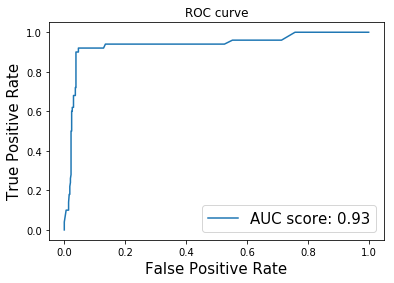

In [31]:
plt.plot(fpr_list, tpr_list, label='AUC score: %.2f' %auc_score);
plt.xlabel('False Positive Rate', fontsize=15);
plt.ylabel('True Positive Rate', fontsize=15);
plt.title('ROC curve');
plt.legend(fontsize=15);

## Part III: Dataset for regression
---
Our final dataset is created for a simple regression task. In the previous two problems, the output of the network represented the class the sample belongs to. Here the output of the network is continuous, a real number. 

Our input dataset consists only of one feature, to keep things simple and easy to visualize. The target y is a vector of real numbers.

Let's create our toy dataset :)!

In [32]:
X, y = make_regression(n_samples=100, n_features=1, n_informative=1, noise=30, 
                       random_state=2018)

### Visualize the input feature and target
----
To get a better glimpse on the problem we're working on, let's plot the input feature with regards to the target.

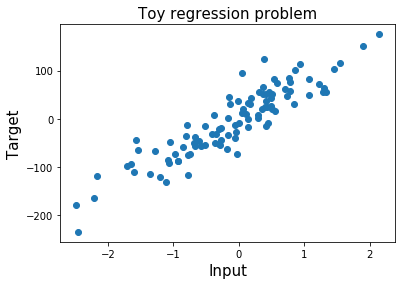

In [33]:
plt.scatter(X, y);
plt.xlabel('Input', fontsize=15);
plt.ylabel('Target', fontsize=15);
plt.title('Toy regression problem', fontsize=15);

In [34]:
# Numpy arrays to tensors
X = tf.constant(X)
y = tf.constant(y)
y = tf.reshape(y, [-1,1]) # change from row vector to column vector

### Neural network for regression task
----
We can re-use the two-layer neural network created above. As we only need to predict one real number, the output size of the network is 1.

We have to redefine our loss function, as we cannot continue using the softmax cross-entropy loss. Instead, we will be using the mean squared error loss function. We will also define a new optimizer, with a smaller learning rate than the previous one. 

Feel free to play here with the number of epochs.

In [35]:
# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(1e-4)

# Initialize model 
model = two_layer_nn(output_size=1, loss_type='regression')

# Select here the number of epochs
num_epochs = 300

# Train the model with gradient descent
model.fit(X, y, optimizer, num_epochs=num_epochs, 
          track_accuracy=False)

### Computing the $R^2$ score (coefficient of determination)
----
If you ever worked on a regression problem, you probably already heard about this score.

This metric computes the percentage of variability between the input features and the target, that is explained by our model. The range of values for the $R^2$ score is between 0 and 1. An $R^2$ score of 1 means that the model makes perfect predictions. An $R^2$ score of 0 is obtained by always predicting the mean of the targets y. 

It is possible to obtain negative values for $R^2$. In this case, it means that our model makes worse predictions than a model which always predicts the mean of the target variable. 

As this metric is not readily available in TensorFlow 1.5, when running in eager mode, I have created a small function for it, in the cell below.

In [36]:
# Compute the R2 score
def r2(labels, predictions):
    mean_labels = tf.reduce_mean(labels)
    total_sum_squares = tf.reduce_sum((labels-mean_labels)**2)
    residual_sum_squares = tf.reduce_sum((labels-predictions)**2)
    r2_score = 1 - residual_sum_squares/total_sum_squares
    return r2_score

preds = model.predict(X)
r2_score = r2(y, preds)
print('R2 score: ', r2_score.numpy())

R2 score:  0.8249999999348803


### Visualizing the line of best fit
----
To visualize the line of best fit of our neural network, we simply take the linear space between X_min and X_max. 

In [37]:
# Create datapoints between X_min and X_max to visualize the line of best fit
X_best_fit = np.arange(X.numpy().min(), X.numpy().max(), 0.001)[:,None]

In [38]:
# Predictions on X_best_fit
preds_best_fit = model.predict(X_best_fit)

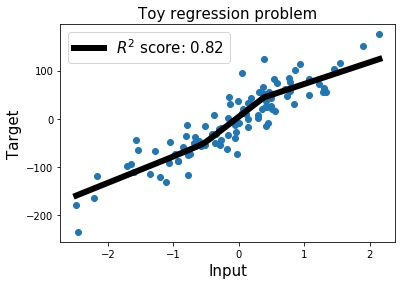

In [39]:
plt.scatter(X.numpy(), y.numpy()); # Original datapoints
plt.plot(X_best_fit, preds_best_fit.numpy(), color='k',
         linewidth=6, label='$R^2$ score: %.2f' %r2_score) # Our predictions
plt.xlabel('Input', fontsize=15);
plt.ylabel('Target', fontsize=15);
plt.title('Toy regression problem', fontsize=15);
plt.legend(fontsize=15);